In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
import pickle

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

SyntaxError: invalid syntax (2198290999.py, line 8)

In [35]:
data = pd.read_csv('Dataset_B_hotel.csv')

In [36]:
data

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0.0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0.0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0.0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0.0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


EDA and Pre-Processing

In [37]:
data.isnull().sum()

Booking_ID                                 0
no_of_adults                               0
no_of_children                             0
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                        907
required_car_parking_space              1270
room_type_reserved                         0
lead_time                                  0
arrival_year                               0
arrival_month                              0
arrival_date                               0
market_segment_type                        0
repeated_guest                             0
no_of_previous_cancellations               0
no_of_previous_bookings_not_canceled       0
avg_price_per_room                      1632
no_of_special_requests                     0
booking_status                             0
dtype: int64

In [38]:
data = data.drop(['Booking_ID'], axis = 1)

Replace missing data in numeric columns with median, because only a small percentage of the data are missing, so replacing the values with median won't make the outcome biased.

In [39]:
median_copper = data['required_car_parking_space'].median()
median_platelets = data['avg_price_per_room'].median()

data['required_car_parking_space'].fillna(median_copper, inplace = True)
data['avg_price_per_room'].fillna(median_platelets, inplace = True)

Make a new category in "type_of_meal_plan"

In [40]:
data['type_of_meal_plan'] = data['type_of_meal_plan'].fillna('Missing')

#Recheck missing values to make sure there's none left
data.isnull().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

Create new feature

In [41]:
data['no_of_guests'] = data['no_of_adults'] + data['no_of_children']

In [42]:
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,no_of_guests
0,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled,2
1,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled,2
2,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled,1
3,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled,2
4,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0.0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled,3
36271,2,0,1,3,Meal Plan 1,0.0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled,2
36272,2,0,2,6,Meal Plan 1,0.0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled,2
36273,2,0,0,3,Not Selected,0.0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled,2


In [43]:
data['type_of_meal_plan'].value_counts()

type_of_meal_plan
Meal Plan 1     27157
Not Selected     4986
Meal Plan 2      3220
Missing           907
Meal Plan 3         5
Name: count, dtype: int64

In [44]:
data['room_type_reserved'].value_counts()

room_type_reserved
Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: count, dtype: int64

In [45]:
data['market_segment_type'].value_counts()

market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64

In [46]:
data['booking_status'].value_counts()

booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64

In [47]:
data = data.replace({'Meal Plan 1': 1, 'Meal Plan 2' : 2, 'Meal Plan 3' : 3, 'Not Selected' : 4, 'Missing' : 5,
                     'Room_Type 1' : 1, 'Room_Type 2' : 2, 'Room_Type 3' : 3, 'Room_Type 4' : 4, 'Room_Type 5' : 5, 'Room_Type 6' : 6, 'Room_Type 7' : 7,
                     'Online' : 1, 'Offline' : 2, 'Corporate' : 3, 'Complementary' : 4, 'Aviation' : 5,
                     'Not_Canceled' : 0, 'Canceled' : 1})

print(data['type_of_meal_plan'].unique())
print(data['room_type_reserved'].unique())
print(data['market_segment_type'].unique())
print(data['booking_status'].unique())

[1 4 2 5 3]
[1 4 2 6 5 7 3]
[2 1 3 5 4]
[0 1]


In [77]:
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,no_of_guests
0,2,0,1,2,1,0.0,1,224,2017,10,2,2,0,0,0,65.00,0,0,2
1,2,0,2,3,4,0.0,1,5,2018,11,6,1,0,0,0,106.68,1,0,2
2,1,0,2,1,1,0.0,1,1,2018,2,28,1,0,0,0,60.00,0,1,1
3,2,0,0,2,1,0.0,1,211,2018,5,20,1,0,0,0,100.00,0,1,2
4,2,0,1,1,4,0.0,1,48,2018,4,11,1,0,0,0,94.50,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,1,0.0,4,85,2018,8,3,1,0,0,0,167.80,1,0,3
36271,2,0,1,3,1,0.0,1,228,2018,10,17,1,0,0,0,90.95,2,1,2
36272,2,0,2,6,1,0.0,1,148,2018,7,1,1,0,0,0,98.39,2,0,2
36273,2,0,0,3,4,0.0,1,63,2018,4,21,1,0,0,0,94.50,0,1,2


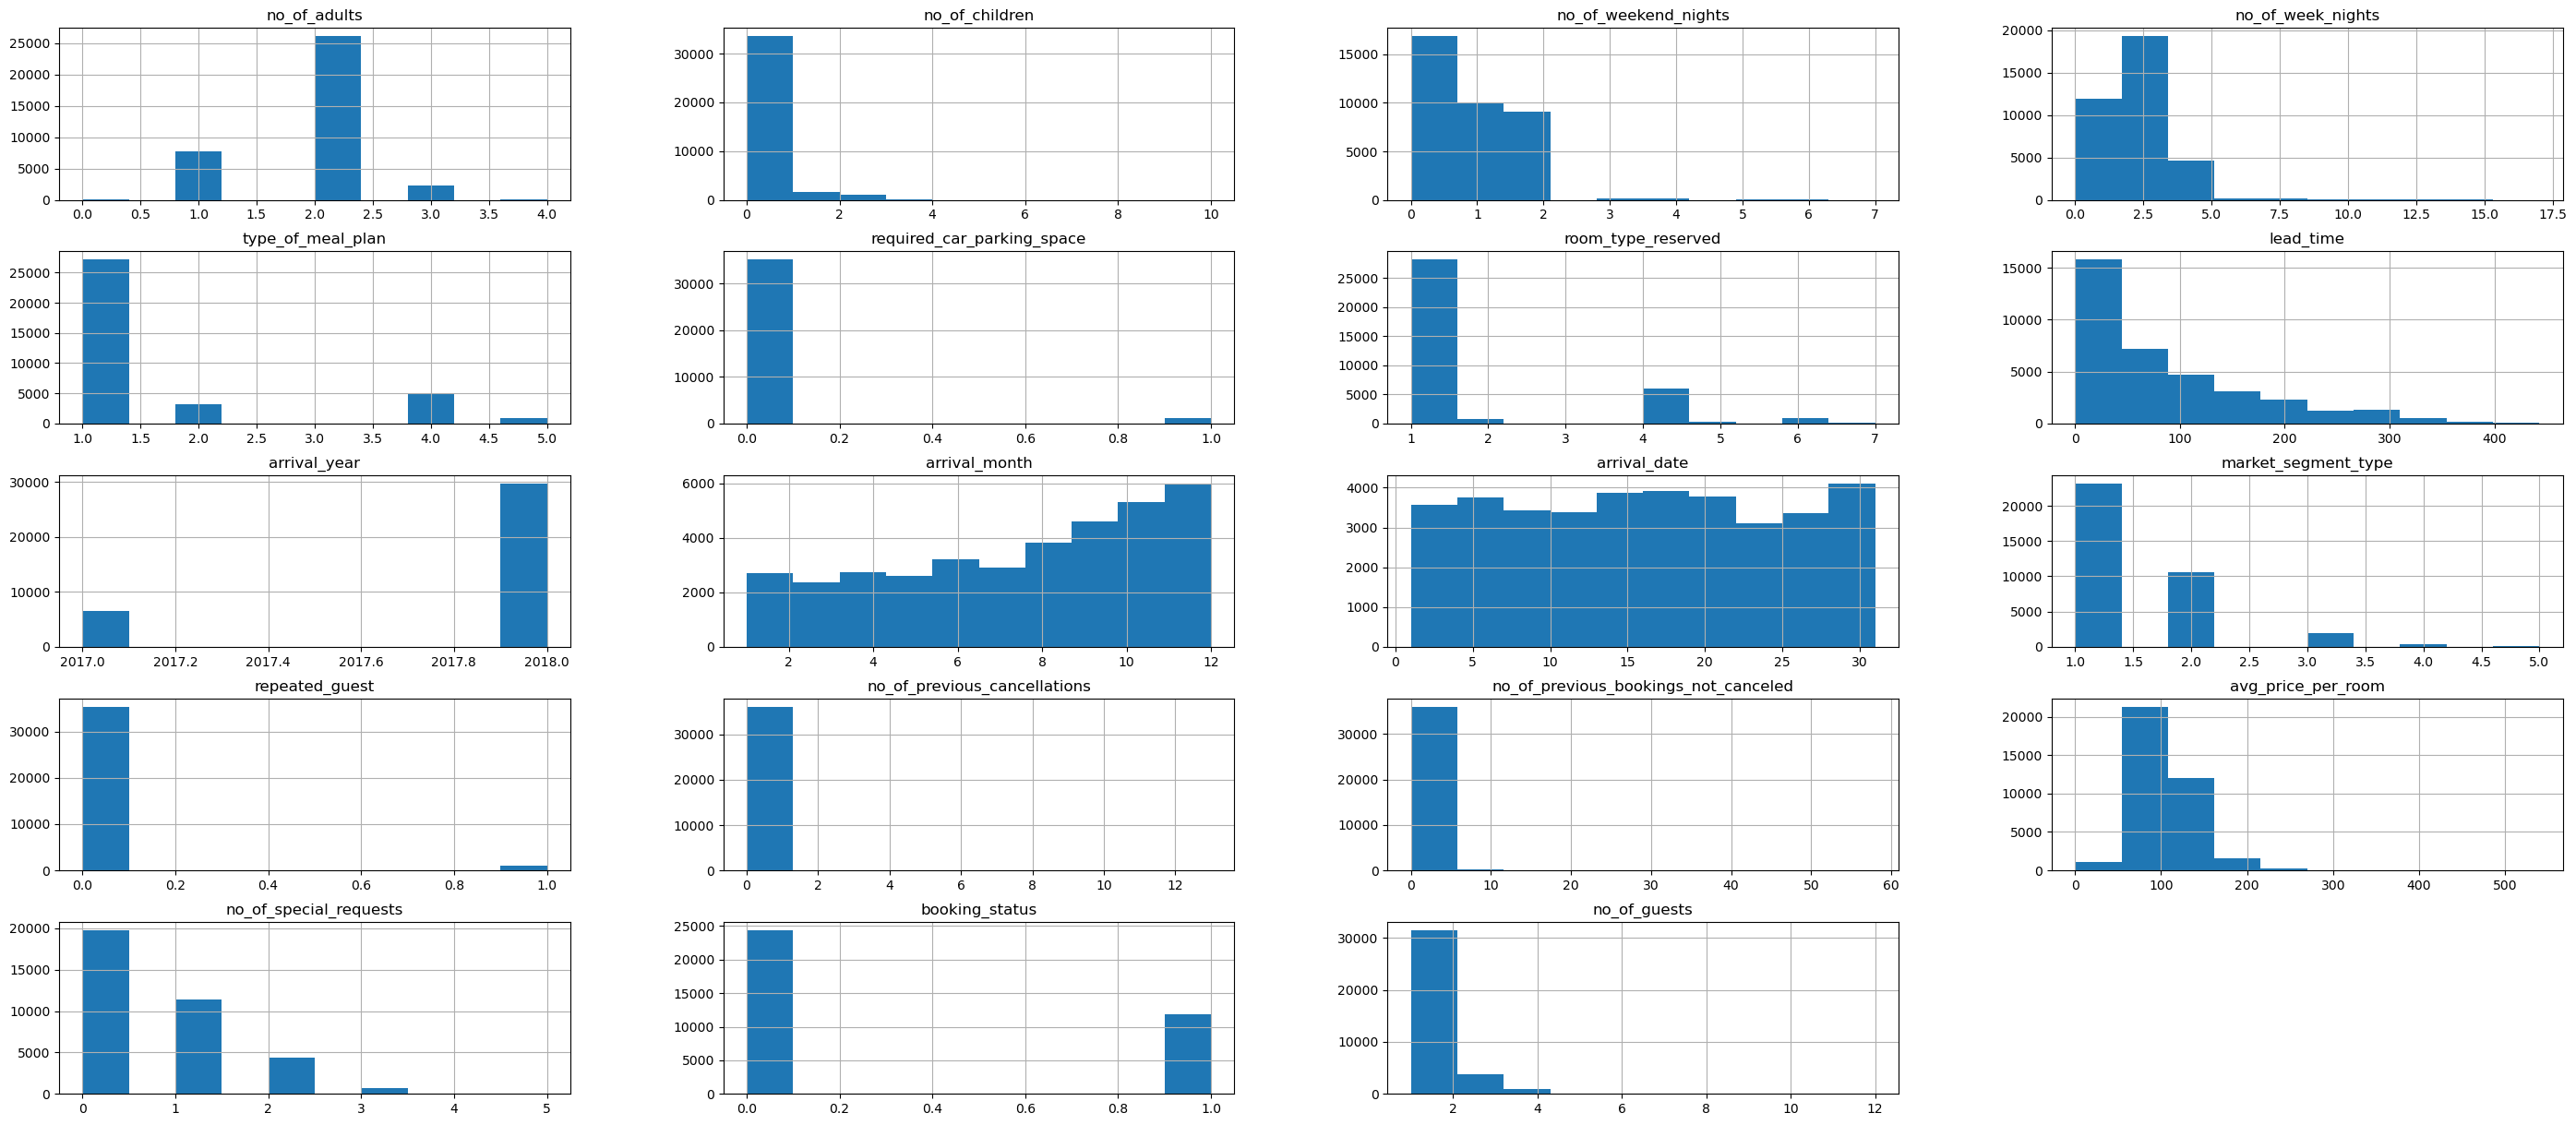

In [48]:
data.hist(figsize=(35,15));

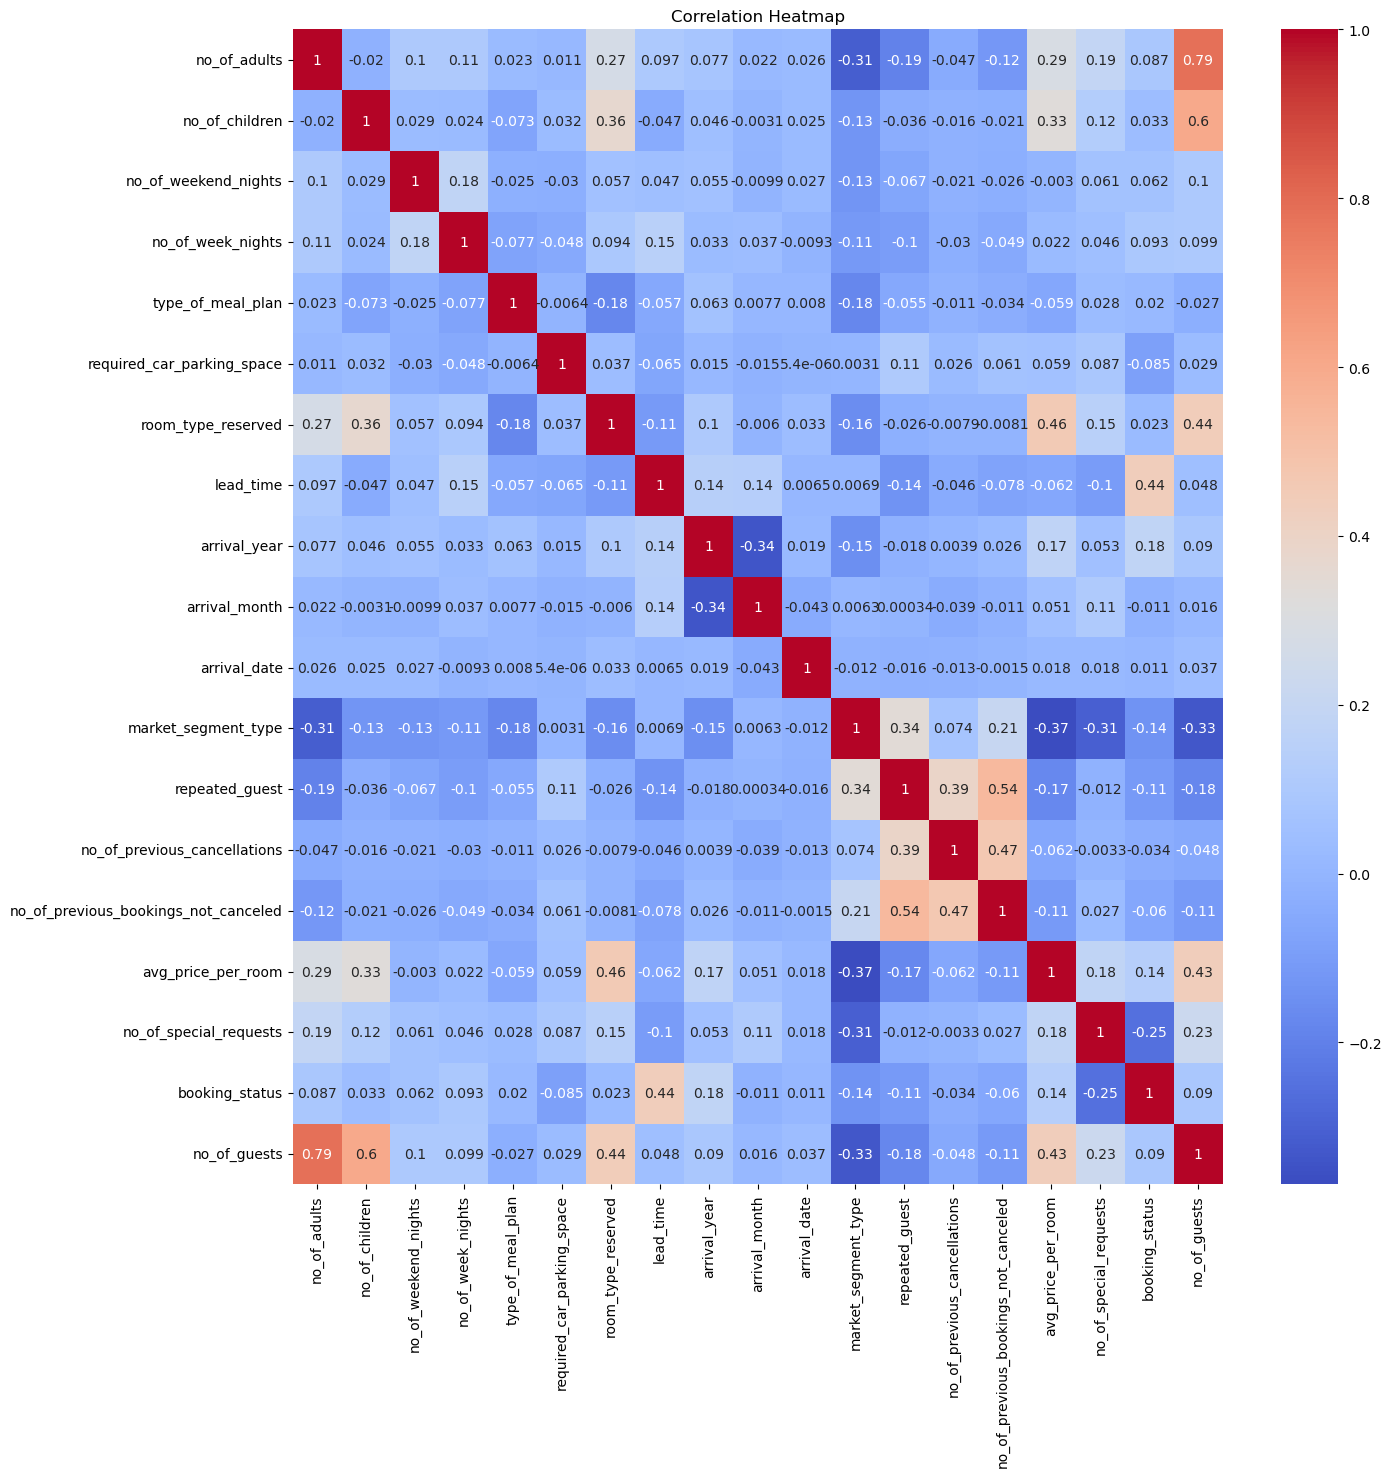

In [50]:
cormatrix = data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(cormatrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Training

In [51]:
#Data Split
x = data.drop(columns = ['booking_status'])
y = data['booking_status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [52]:
#RANDOM FOREST
print("RANDOM FOREST")
#Hyperparameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 20, 30]
}

rf = RandomForestClassifier(random_state = 42)

grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, cv = 5, scoring = 'accuracy')
grid_rf.fit(x_train, y_train)

print("Best Parameters:", grid_rf.best_params_)

best_param_rf = grid_rf.best_estimator_
y_pred = best_param_rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division = 0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RANDOM FOREST
Best Parameters: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy: 0.898828394210889

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      4839
           1       0.89      0.80      0.84      2416

    accuracy                           0.90      7255
   macro avg       0.90      0.87      0.88      7255
weighted avg       0.90      0.90      0.90      7255


Confusion Matrix:
[[4597  242]
 [ 492 1924]]


In [53]:
#XGBOOST
print("XGBOOST")
#Hyperparameters
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.3, 0.5, 0.7]
}

xgboost = XGBClassifier(num_class = 4, objective = 'multi:softmax')
xgboost.fit(x_train, y_train)

grid_xgb = GridSearchCV(estimator = xgboost, param_grid = param_grid_xgb, cv = 5, scoring = 'accuracy')
grid_xgb.fit(x_train, y_train)

print("Best Parameters:", grid_xgb.best_params_)

best_param_xgb = grid_xgb.best_estimator_
y_pred = best_param_xgb.predict(x_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_xgb)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division = 0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

XGBOOST
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Accuracy: 0.8975878704341833

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      4839
           1       0.87      0.81      0.84      2416

    accuracy                           0.90      7255
   macro avg       0.89      0.88      0.88      7255
weighted avg       0.90      0.90      0.90      7255


Confusion Matrix:
[[4556  283]
 [ 460 1956]]


Training (OOP)

In [ ]:
#Data Split
class DataSplit:
    def __init__(self, target_column, test_size=0.2, random_state=42):
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state

    def split(self, data):
        x = data.drop(columns=[self.target_column])
        y = data[self.target_column]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, 
            test_size=self.test_size, 
            random_state=self.random_state
        )
        return x_train, x_test, y_train, y_test

In [59]:
splitter = DataSplit(target_column='booking_status')
x_train, x_test, y_train, y_test = splitter.split(data)

In [64]:
class RandomForestTrain:
    def __init__(self, param_grid=None, random_state=42):
        if param_grid is None:
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, 30],
                'min_samples_split': [10, 20, 30]
            }

        self.param_grid = param_grid
        self.model = RandomForestClassifier(random_state=random_state)
        self.grid_search = None
        self.best_model = None

    def train(self, x_train, y_train):
        self.grid_search = GridSearchCV(estimator=self.model, param_grid=self.param_grid, cv=5, scoring='accuracy')
        self.grid_search.fit(x_train, y_train)
        self.best_model = self.grid_search.best_estimator_

    def evaluate(self, x_test, y_test):
        if self.best_model is None:
            raise ValueError("Model has not been trained yet.")

        y_pred = self.best_model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)

        print("Best Parameters:", self.grid_search.best_params_)
        print("Accuracy:", accuracy)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        return accuracy, y_pred

In [ ]:
rf_model = RandomForestTrain()
rf_model.train(x_train, y_train)
accuracy, y_pred = rf_model.evaluate(x_test, y_test)

Best Parameters: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy: 0.898828394210889

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      4839
           1       0.89      0.80      0.84      2416

    accuracy                           0.90      7255
   macro avg       0.90      0.87      0.88      7255
weighted avg       0.90      0.90      0.90      7255


Confusion Matrix:
[[4597  242]
 [ 492 1924]]


In [100]:
#Save as PKL File
joblib.dump(rf_model.best_model, "rf_model.pkl")
print("Model saved as rf_model.pkl")

Model saved as rf_model.pkl


In [129]:
class ModelInference:
    def __init__(self, model_path):
        # Load the model
        self.model = joblib.load(model_path)  # Loading the model
        if not hasattr(self.model, 'predict'):
            raise ValueError("The loaded object is not a valid model with a 'predict' method.")
        
    def predict(self, input_data):
        # Ensure the input data is in a DataFrame format
        if isinstance(input_data, dict):
            input_data = pd.DataFrame([input_data])  # Convert dict to DataFrame
        
        if isinstance(input_data, pd.DataFrame):
            # Ensure the DataFrame is passed to predict
            prediction = self.model.predict(input_data)  # Make prediction with the model
            return prediction
        else:
            raise ValueError("Input data must be a DataFrame or dict.")

In [131]:
inference = ModelInference("rf_model.pkl")

sample = {
    'no_of_adults': 3,
    'no_of_children': 1,
    'no_of_weekend_nights': 2,
    'no_of_week_nights': 5,
    'type_of_meal_plan': 2,
    'required_car_parking_space': 1.0,
    'room_type_reserved': 3,
    'lead_time': 157,
    'arrival_year': 2017,
    'arrival_month': 7,
    'arrival_date': 14,
    'market_segment_type': 1,
    'repeated_guest': 0,
    'no_of_previous_cancellations': 1,
    'no_of_previous_bookings_not_canceled': 2,
    'avg_price_per_room': 98.75,
    'no_of_special_requests': 2,
    'no_of_guests': 4
}

# Create the ModelInference object
inference = ModelInference("rf_model.pkl")

# Make a prediction
prediction = inference.predict(sample)

# Print the result
print("Prediction:", prediction)

Prediction: [0]
